![](https://chendongze.oss-cn-shanghai.aliyuncs.com/ipic/ihkvn.png)

# 下载处理后的数据库数据库

In [1]:
# !gdown --id 18x-aCvxJpOrWJoZ5VAuIe-xzNJHH9lqH

In [2]:
# 从用 base 环境

In [3]:
# !unzip pop17.zip -d pop17-dataset

# 我最终使用的数据源叫 [[Pop1K7]]，
# 由[[台湾人工智慧实验室]]开源，
# 它包含了 1700 首[[ MIDI ]]钢琴音乐。
# 我也尝试过自制[[爵士乐]]的数据源，即通过转录（transcript）技术将大量爵士乐纯音频转换成[[ MIDI]]，
# 但发现生成的[[ MIDI ]]文件会有个别错音，
# 因此仍需要一次人工校正，工作量太大，所以放弃，选用[[开源数据源]]。

In [4]:
# requirement 文件中需要安装的内容

# !pip install miditok==1.1.4
# !pip install miditoolkit==0.1.15
# !pip install tensorflow_probability==0.14.1
# !pip install tqdm==4.55.1

# !pip install numpy

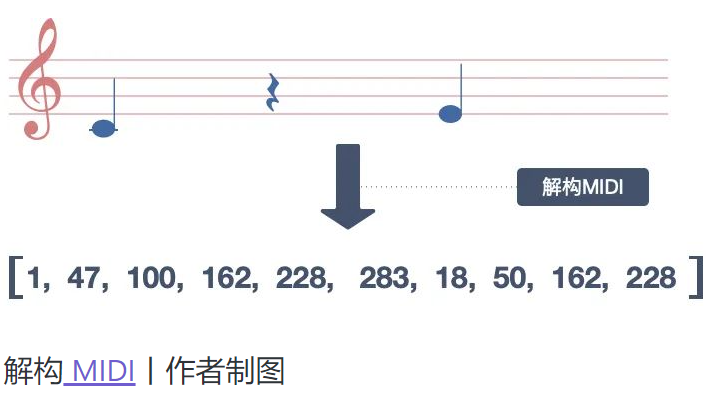
结构 midi

In [5]:
from Model import *
from utils import batch
import math
import random
from dataset import CP_Word_Dataset  # 这是一个py文件，数据集的事情都在那里处理了


## 设置模型与训练参数

In [6]:
train_seq_length = 1025
database_name = 'pop17'
eval_out_path = './pop17-dataset/pop17_eval_dataset.json'
train_out_path = './pop17-dataset/pop17_train_dataset.json'
test_out_path = './pop17-dataset/pop17_test_dataset.json'
log_dir = './tf_logs/'
checkpoint_dir = './hy-tmp/checkpoints/'


In [7]:
# Train

epoch = 1
batch_size = 5
warmup_steps = 4000
save_n_step = 20
setLogs_n_step = 20
save_test_best_n_step = 500
test_start_step = 5000
reset_states_n_step = 20

In [8]:
# [Family Bar/position Pitch Velocity Duration Chord Rest Tempo]
# [family 酒吧/位置     音高 速度     持续    和弦   休息  节奏] 
# 刚好八个参数特征

# [[  3   1   4  93 126 224 242 252]
#  [  3   1   4  93 126 224 242 252]
#  [  3 192   4  93 126 224 242 258]
#  [  2 191  46 109 151 224 242 252]
#  [  2 191  53 109 151 224 242 252]]

# 生成的数据的前五个，都是七个参数 相对应的数据的含义？

token_range = [2, 34, 89, 33, 65, 18, 10, 33]
emb_sizes = [32, 64, 256, 128, 128, 64, 64, 64]

vocab_sizes = [i+2 for i in token_range]
eos_tokens = [i+1 for i in token_range]

eos_tokens = vocab2token([eos_tokens])[0]
random.seed(1)  # for data

config = {
    "vocab_sizes": vocab_sizes,
    "emb_sizes": emb_sizes,
    "d_model": 128,
    "dff": 1024,
    "num_layers": 4,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "length": 1024,
    "rpr": True,
    "dataset": f'{database_name}_{train_seq_length}',
}

## 初始化模型

In [9]:
mt = model().getLinearTransformerXL(config,  # 获取线性transformer  是一种结构 
                                    log_dir,
                                    checkpoint_dir)


# XL 是什么？

## 加载权重

In [10]:
if len(os.listdir(mt.checkpoint_dir)) > 0:
    checkpoint_path = f"{mt.checkpoint_dir}/lastest-ckpt" # check point？ 
    print(f'load:{checkpoint_path}')
    mt.load_weights(checkpoint_path)
    

# 查看模型

In [11]:
inp = tf.constant([[[1, 1, 1, 1, 1, 1, 1, 1]]], 
                  tf.int64)

r, w = mt(inp,
          True,
          inp)

mt.summary()

In [12]:
# 绘制模型结构图【没能绘制成功，图在内部】

from keras.utils.vis_utils import plot_model

# 输出可视化图片
# 参数：model为你的模型，to_file保存文件名，show_shapes是否显示输入输出尺寸

plot_model(mt, 
           to_file='linear_transformer_xl.png', 
           show_shapes=True,
           show_layer_names=True,
           expand_nested=True,
           dpi=100
          )

## 存放 run state

In [13]:
train_cache_dir = f'{mt.log_dir}/train_process.json'
train_process_json = Train_process_json(train_cache_dir)


In [14]:
# 读取json 的内容

import json

path='data'

f = open(train_cache_dir,'r',encoding='utf-8')

m = json.load(f) # json.load() 这种方法是解析一个文件中的数据
				 # json.loads() 需要先将文件，读到一个变量作为字符串, 解析一个字符串中的数
print(m)

## 设置训练信息

In [15]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=warmup_steps):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        self.step = 0
        self.lr = 0

        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        lr = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

        self.step = step
        self.lr = lr
        return lr
    

In [16]:
learning_rate = CustomSchedule(config['d_model'])

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate,  # 学习率
                                     beta_1=0.9, 
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [18]:
def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [19]:
# Sparse Categorical Crossentropy 稀疏 分类 交叉熵

In [20]:
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [21]:

mt.train_setup(loss_function,
               accuracy_function,
               optimizer  # 优化
              )


### **Loss function**，即[[损失函数]]：
用于定义<mark style="background: #BBFABBA6;">单个训练样本</mark> 与真实值之间的误差；

### **Cost function**，即[[代价函数]]：
用于定义<mark style="background: #ABF7F7A6;">单个批次/整个训练集</mark> 样本与真实值之间的误差；

### **Objective function**，即[[目标函数]]：
泛指任意可以被优化的函数。

## 读取训练状态


In [22]:
best_acc = train_process_json.get()['best_acc']
best_loss = train_process_json.get()['best_loss']
current_step = train_process_json.get()['step']

In [23]:
print(best_acc, 
      best_loss, 
      current_step
     )

## 配置tf-logs

In [24]:
stat_names = ['Family', 'Position', 'Pitch',
              'Velocity', 'Duration', 'Chord', 
              'Rest', 'Tempo', 'Total']

train_losses = [tf.keras.metrics.Mean(
    name=f'{n}_loss') for n in stat_names]
train_accuracy = [tf.keras.metrics.Mean(
    name=f'{n}_accuracy') for n in stat_names]

eval_losses = [tf.keras.metrics.Mean(
    name=f'{n}_loss') for n in stat_names]
eval_accuracy = [tf.keras.metrics.Mean(
    name=f'{n}_accuracy') for n in stat_names]

train_summary_writer = tf.summary.create_file_writer(f'{mt.log_dir}/train_dir')
eval_summary_writer = tf.summary.create_file_writer(f'{mt.log_dir}/eval_dir')
test_summary_writer = tf.summary.create_file_writer(f'{mt.log_dir}/test_dir')

In [25]:

def setLogs():
    step = current_step
    with train_summary_writer.as_default():
        for l in train_losses:
            tf.summary.scalar(l.name, l.result(), step=step)
        for a in train_accuracy:
            tf.summary.scalar(a.name, a.result(), step=step)
    with eval_summary_writer.as_default():
        for l in eval_losses:
            tf.summary.scalar(l.name, l.result(), step=step)
        for a in eval_accuracy:
            tf.summary.scalar(a.name, a.result(), step=step)
            

In [26]:
def reset_states():
    for t in train_losses:
        t.reset_states()
    for t in train_accuracy:
        t.reset_states()
    for t in eval_losses:
        t.reset_states()
    for t in eval_accuracy:
        t.reset_states()

## 定义 ckpt 保存函数

In [27]:
ckpt 是什么？

In [28]:
def save_lastest_ckpt():
    train_process_json.set(current_step, best_acc, best_loss)
    mt.save_weights(
        f'{mt.checkpoint_dir}/lastest-ckpt', overwrite=True, save_format="tf")

In [29]:
def save_test_best_ckpt(loss, acc):
    global best_acc
    global best_loss

    if(acc > best_acc):
        best_acc = acc
        train_process_json.set(current_step, best_acc, best_loss)
        mt.save_weights(
            f'{mt.checkpoint_dir}/best_acc-ckpt{current_step}', overwrite=True, save_format="tf")

    if(loss < best_loss):
        train_process_json.set(current_step, best_acc, best_loss)
        best_loss = loss
        mt.save_weights(
            f'{mt.checkpoint_dir}/best_loss-ckpt{current_step}', overwrite=True, save_format="tf")

    mt.save_weights(f'{mt.checkpoint_dir}/ckpt{current_step}',
                    overwrite=True, save_format="tf")

    with test_summary_writer.as_default():
        tf.summary.scalar('test_loss', loss, step=current_step)
        tf.summary.scalar('test_acc', acc, step=current_step)

## 开始训练

In [30]:
for e in range(epoch):

    eval_ds = CP_Word_Dataset(eval_out_path, train_seq_length, eos_tokens)
    print('eval_ds length', eval_ds.total_seq)

    train_ds = CP_Word_Dataset(train_out_path, train_seq_length, eos_tokens)
    print('train_ds length', train_ds.total_seq)

    test_ds = CP_Word_Dataset(test_out_path, train_seq_length, eos_tokens)
    print('test_ds length', test_ds.total_seq)
    
        # eval_ds length 9107
        # train_ds length 76346
        # test_ds length 10404

    train_step_per_epoch = math.ceil(train_ds.total_seq / batch_size)
    eval_step_per_epoch = math.ceil(eval_ds.total_seq / batch_size)

    current_epoch = math.ceil(current_step / train_step_per_epoch)

    train_data_range_idxs = random.sample(
        range(train_ds.total_seq), train_ds.total_seq)

    eval_data_range_idxs = random.sample(
        range(eval_ds.total_seq), eval_ds.total_seq)

    with tqdm(total=train_step_per_epoch) as bar:
        idx = 0
        train_seq_start_idx = current_step % train_step_per_epoch * batch_size

        for batch_idxs in batch(train_data_range_idxs[train_seq_start_idx:], batch_size):

            # train
            seqs = train_ds.get_seqs(batch_idxs)  # (batch_size, length, 6)
            losses, acc = mt.train_step(np.array(seqs))
            current_step += 1
            current_lr = learning_rate(tf.cast(current_step, tf.float32))

            for i in range(len(losses)):
                train_losses[i](losses[i].numpy())
                train_accuracy[i](acc[i])
            train_losses[-1](np.sum([l.numpy()
                             for l in losses]) / len(losses))  # 均值
            train_accuracy[-1](np.sum(acc) / len(losses))

            # eval
            e_start_idx = current_step % eval_step_per_epoch * batch_size
            eval_batch_idxs = eval_data_range_idxs[e_start_idx: e_start_idx + batch_size]

            eval_seqs = eval_ds.get_seqs(eval_batch_idxs)
            e_losses, e_acc = mt.eval(eval_seqs)

            for i in range(len(losses)):
                eval_losses[i](e_losses[i].numpy())
                eval_accuracy[i](e_acc[i])

            eval_losses[-1](np.sum([l.numpy()  # 损失函数
                            for l in e_losses]) / len(e_losses))  # 均值
            eval_accuracy[-1](np.sum(e_acc) / len(e_losses)) # 精确函数？
            
            # 对于一个样本的预测值，其最大概率的下标作为该样本的预测结果，
#             然后与 y_true 的最大下标进行对比，如果下标相同，则预测正确。

            if idx % setLogs_n_step == 0:
                setLogs()

            if idx % save_n_step == 0:
                save_lastest_ckpt()

            # if idx % save_eval_best_n_step == 0:
            #     save_eval_best_ckpt()

            if current_step % save_test_best_n_step == 0 and current_step > test_start_step:
                loss, acc = mt.test(test_ds, batch_size)
                save_test_best_ckpt(loss, acc)

            # [Family Bar/position Pitch Velocity Duration Tempo] #[家庭酒吧/位置音高速度持续时间节奏]
            
            bar.set_description(
                f'Epoch/step {current_epoch}/{current_step}: lr {float(current_lr):.6}  Loss/eval/best {float(train_losses[-1].result()):.6}/{float(eval_losses[-1].result()):.6}/{best_loss:.6}  Acc/eval/best {float(train_accuracy[-1].result()):.6}/{float(eval_accuracy[-1].result()):.6}/{best_acc:.6}'
            )
            if idx == 0:
                bar.update(current_step % train_step_per_epoch)
            bar.update(1)

            if idx % reset_states_n_step == 0:
                reset_states()
            idx += 1


In [31]:
# 这里训练完成了，得到的是什么？ 令牌嘛

## 生成 MIDI

In [32]:
from dataset import get_tokenizer # dataset.py 文件中的函数
import datetime

In [33]:
ckpt = 'lastest-ckpt'

if len(os.listdir(mt.checkpoint_dir)) > 0:
    checkpoint_path = f"{mt.checkpoint_dir}/{ckpt}"
    print(f'load:{checkpoint_path}')
    mt.load_weights(checkpoint_path)

# from dataset import get_tokenizer    
tokenizer = get_tokenizer()

print(tokenizer)

seed_length = 10 # 种子长度
length = 500 
temperature = [0.05, 0.01, 1, 1, 1.1, 0.01, 1, 0.01]
nucleus_p = [False, 0.9, 0.9, 0.9, 0.95, 0.9, 0.9, 0.9] # 核 p


if_end = False  # Fasle 为屏蔽 EOS Token



seqs = np.array(eval_ds.get_seqs([0]))
inp = seqs[:batch_size, :seed_length]



gen = mt.generate(np.array(inp), int(length), temperature, nucleus_p, if_end)
tokens = [vocab2token(g) for g in gen]
current_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

# # [[TOP-P Sampling ]]的核心是可以甩掉末尾的小概率，可通过设置参数 P 来配置候选者的数量，
#     P 的值越大则参选的候选者越少。
# # Temperature Sampling 则给了我一个可调节的“温度”参数，
#     即可通过调整温度 T 来把控旋律的变化幅度。

idx = 0

In [34]:
# 这边生成的数据是什么样式的？

print(tokens)

# 数据结构是？

#  【答案】'list' object

print(len(tokens))
# 是不是多了一层？

tokens_0=tokens[0]

print(tokens_0)

print(len(tokens_0))

In [35]:
print(tokens[0][0:5])

In [36]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

y = tokens[0]
# print "y = %s"% y
x = range(len(y))
# print "x=%s"% x
plt.plot(y)
plt.show()

In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

y = tokens[0][0:50]
# print "y = %s"% y
x = range(len(y))
# print "x=%s"% x
plt.plot(y)
plt.show()

In [38]:
print(tokens)

In [39]:
for midi_token in tokens:
     print(midi_token)

# tokenizer.tokens_to_midi 这个命令该如何使用？ 
# 由tokens令牌文件生成midi文件
# 源自 miditok 库


# 我尝试搜寻“[[MIDI Tokenize]]”，老天眷顾，
# 我找到了一套刚发布一周的开源[[ MIDI Tokenize ]]方案“[[miditok]]”，
# 是[[索邦大学]]的一名叫 [[Natooz ]]的博士生做的。

# 有了这个项目的支持，[[解构 MIDI ]]便水到渠成了，这时拆解一首曲子，
# 就如同把玩具拆成最基本的乐高积木，
# 将这些乐高积木与数字一一映射，最终就得到了一串数字序列，
# 这就是 AI 能听懂的音符了。

# **[[拿到了音符对应的数字]]，是个好彩头。
# 但接下来的才是真正的挑战——[[要让 AI 在连绵不绝的数字中寻找规律]]。


In [40]:
# 原版【报错】
#     函数的问题

    # 这里是要生成midi文件
    # 由tokens令牌文件生成midi文件
    # tokens_to_midi  这么个函数，到底该怎么用啊？

print(tokens)

for midi_token in tokens:
    print(len(midi_token))
    print(midi_token)

    converted_back_midi = tokenizer.tokens_to_midi(np.array([midi_token]), [(0, False)])
    converted_back_midi.dump(f'./gen_midi/{idx}-{temperature}-{nucleus_p}-{length}.{current_time}.midi')
    
    idx += 1

#     MIDI文件的开发是为了允许音乐家和音频开发人员将MIDI数据从一个软件应用程序传输到另一个软件应用程序。
#     MIDI文件包含指定符号、音高、速度和音量、颤音、音频平移的控制信号的消息，这些信息可以在多个设备之间同步节奏。
#     以前你需要四种独立的键盘乐器，但现在有了MIDI文件，你可以用一个控制器演奏多种乐器。
    
#     dump 转储
    

In [41]:
# 改进版本
for midi_token in tokens:
    
    midi_token_array = np.array([midi_token])
    print(midi_token_array)
    print(len(midi_token_array))
    print('\n')
    print(midi_token_array, [(0, False)])
    print('\n')

    print(tokenizer.tokens_to_midi(midi_token_array, [(0, False)]))
    
    converted_back_midi = tokenizer.tokens_to_midi(midi_token_array, [(0, False)])
    
    converted_back_midi.dump(f'./gen_midi/{idx}-{temperature}-{nucleus_p}-{length}.{current_time}.midi')
    idx += 1

# jupyter 插件

In [42]:
!jupyter labextension list

In [43]:
!jupyter lab paths

In [44]:
# 构建失败编译500失败，请在服务器上运行“jupyter lab Build”以获得完整输出
!jupyter lab Build

# tensorboard


In [45]:
# print(mylogdir)

In [46]:
!tensorboard --logdir mylogdir

In [47]:
# !tensorboard --helpfull

In [48]:
!tensorboard dev upload --logdir \ 'mylogdir' -y